In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
import os
from scipy import signal
import scipy as sp

In [2]:
from statsmodels.tsa.ar_model import AR

def iemg(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Integrated EMG which is the summation of the absolute values of the EMG signal amplitude.
    It is used as an onset index to detect muscle activity.
    """
    return np.sum(np.abs(data), axis=1)


def mav(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Mean Absolute Value which is the average of the absolute values of the EMG signal.
    It is used for the detection of muscle contraction levels.
    """
    return np.mean(np.abs(data), axis=1)


def mmav1(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Modified Mean Absolute Value 1 which is an extension of the MAV by applying a discrete
    weighting window function.
    """
    llim = int(0.25 * data.shape[1])
    hlim = int(0.75 * data.shape[1]) + 1
    r1 = np.arange(0, llim)
    r2 = np.arange(llim, hlim)
    r3 = np.arange(hlim, data.shape[1])

    return np.mean(np.concatenate((np.abs(np.take(data, r1, axis=1)) * 0.5, np.abs(np.take(data, r2, axis=1)),
                                   np.abs(np.take(data, r3, axis=1)) * 0.5), axis=1), axis=1)


def mmav2(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Modified Mean Absolute Value 2 which is similar to MMAV2 but a smoother continuous
    weighting window function is used.
    """
    llim = int(0.25 * data.shape[1])
    hlim = int(0.75 * data.shape[1]) + 1
    r1 = np.arange(0, llim)
    r2 = np.arange(llim, hlim)
    r3 = np.arange(hlim, data.shape[1])
    c1 = (4 * (r1 + 1) / data.shape[1])[np.newaxis, :, np.newaxis]
    c2 = (4 * (r3 + 1 - data.shape[1]) / data.shape[1])[np.newaxis, :, np.newaxis]

    return np.mean(np.concatenate((np.abs(np.take(data, r1, axis=1)) * c1, np.abs(np.take(data, r2, axis=1)),
                                   np.abs(np.take(data, r3, axis=1)) * c2), axis=1), axis=1)


def ssi(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Simple Square Integral which is the energy of the sEMG signal segment.
    """
    return np.sum(np.power(np.abs(data), 2), axis=1)


def variance(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Variance which is the average of the square of the signal's deviation from the mean.
    It uses the signals power as a feature.
    """
    return np.var(data, axis=1)


def rms(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Root Mean Square which is the standard deviation of the signal amplitude values.
    It is related to the constant force and non-fatiguing contraction of the muscle.
    """
    return np.sqrt(np.mean(data ** 2, axis=1))


def wl(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Waveform Length which is the cumulative length of the waveform over the time segment.
    It is related to the waveform amplitude, frequency and time.
    """
    return np.sum(np.abs(np.diff(data, axis=1)), axis=1)


def zc(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Zero Crossing which is the number of times the signal values cross zero.
    It provides an approximation of the signal frequency. The threshold used is for reducing the effect of noise.
    """
    return np.count_nonzero(np.diff(np.sign(data), axis=1), axis=1)


def ssc(data, th=20): 
    """
    :param data: EMG signal samples within rolling window
    :param th: Threshold used to reduce noise effects
    :return: Slope Sign Changes which is the number of changes between positive and negative slopes of the signal.
    It also provides information about the signal frequency. The threshold used is for reducing the effect of noise.
    """
    return np.sum((-np.diff(data, prepend=1, axis=1)[:, 1:-1, :] * np.diff(data, axis=1)[:, 1:, :]) > th, axis=1)


def wamp(data, th=20):
    """
    :param data: EMG signal samples within rolling window
    :param th: Threshold used to reduce noise effects
    :return: Wilson's Amplitude which is the number of times that the difference between two consecutive signal segments
    passes a certain threshold, which is also used to reduce the effect of noise. WAMP is related to the firing of
    motor unit action potentials (MUAP) and the muscle contraction levels.
    """
    x = np.abs(np.diff(data, axis=1))
    above = x > th
    return np.sum(above, axis=1)


def kurtosis(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Kurtosis which is a statistical measure that defines how the tails of a distribution differs
    from the tails of a normal distribution. It identifies the presence of extreme values in the EMG signal.
    """
    return sp.stats.kurtosis(data, axis=1)


def skewness(data):
    """
        :param data: EMG signal samples within rolling window
        :return: Skewness which measures the lack of symmetry of a distribution. It also identifies the
        presence of extreme values in the EMG signal.
        """
    return sp.stats.skew(data, axis=1)

def sd(data):
    return np.std(data, axis=1)

def mean(data):
    return np.mean(data, axis=1)

'''def ar_coefficients(signal, p=11):
    ar_model = AR(signal)
    ar_res = ar_model.fit(p,trend='nc') 
    ar_coefficients = ar_res.params

    return ar_coefficients.tolist()'''

"def ar_coefficients(signal, p=11):\n    ar_model = AR(signal)\n    ar_res = ar_model.fit(p,trend='nc') \n    ar_coefficients = ar_res.params\n\n    return ar_coefficients.tolist()"

In [3]:
supported_features = {"iemg": iemg, "mav": mav,
                      "mmav1": mmav1, "mmav2": mmav2,
                      "ssi": ssi, "rms": rms,
                      "wl": wl, "zc": zc,
                      "ssc": ssc, "wamp": wamp,
                      "kurtosis": kurtosis,
                      "skewness": skewness,
                      "var": variance, "sd": sd,
                      "mean": mean}

In [4]:
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, iirnotch, filtfilt

def load_file(filename):
    mat = io.loadmat(filename)
    data = pd.DataFrame(mat['emg'])
    data['stimulus'] = mat['restimulus']
    data['repetition'] = mat['repetition']
    data['subject'] = mat['subject'].repeat(data.shape[0], axis=0)
    return data

def extract_exercise(file_name):
    ex_num = int(file_name.split(".")[0].split("_")[1][1])
    return ex_num

def get_data(data_dir, exercises=[1,2,3]):
    data = []
    for root, dirs, files in os.walk(data_dir):
        for f in files:
            ex_num = extract_exercise(f)
            if(ex_num in exercises):
                data.append(load_file(os.path.join(root, f)))
    return data

def _butter_highpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
    return b, a

def butter_highpass_filter(data, cutoff=2, fs=200, order=3):
    b, a = _butter_highpass(cutoff=cutoff, fs=fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

def extract_features(rolled_emg, feature_set):
    """
    Extract features from EMG data after rolling window.
    :return: None
    """
    extracted_features = []
    for feature in feature_set:
        feat_func = supported_features.get(feature.lower(), None)
        if feat_func:
            ex_feat = feat_func(rolled_emg)
            extracted_features.append(ex_feat)
        else:
            print(f"Feature {feature} not supported yet")
    if len(extracted_features):
        extracted_features = np.hstack(extracted_features)
    else:
        print("No features have been extracted")
    return extracted_features

'''def extract_features(df_list, features_list=['Mean', 'Variance', 'SD', 'Skewness', 'Kurtosis', 'RMS']):
    all_feats = np.empty((1, 16*len(features_list)+2))
    for i, df in enumerate(df_list):
        data, y, reps = roll_window(df)
        feats = np.mean(data, axis=1)
        if("Variance" in features_list):
            feats = np.hstack((feats, variance(data)))
        if("SD" in features_list):
            feats = np.hstack((feats, np.std(data, axis=1)))
        if("Skewness" in features_list):
            feats = np.hstack((feats, skewness(data)))
        if("Kurtosis" in features_list):
            feats = np.hstack((feats, kurtosis(data)))
        if("RMS" in features_list):
            feats = np.hstack((feats, rms(data)))
        
        feats = np.hstack((feats, reps.reshape((-1,1)), y.reshape((-1, 1))))
        all_feats = np.vstack((all_feats, feats))
    return all_feats'''

def roll_window_op(data, win_len=52, stride=5):
    return sliding_window_view(data, win_len, axis=0)[::stride, :]

def roll_window(data, win_len=50, win_stride=25):
    idx = [i for i in range(win_len, len(data), win_stride)]
    X = np.zeros([len(idx), win_len, len(data.columns) - 3])
    y = np.zeros([len(idx), ])
    reps = np.zeros([len(idx), ])
  
    for i, end in enumerate(idx):
        start = end - win_len
        X[i] = data.iloc[start:end, 0:16].values
        y[i] = data.iloc[start, 16]
        reps[i] = data.iloc[start, 17]

    return X, y, reps

In [5]:
data = get_data('F:/01UOttawa/Graduation project/models notebook/Dataset/data', [2])
len(data)

10

<AxesSubplot:>

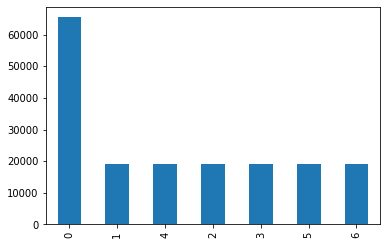

In [6]:
data[1].repetition.value_counts().plot.bar()

In [15]:
data[0].columns

Index([           0,            1,            2,            3,            4,
                  5,            6,            7,            8,            9,
                 10,           11,           12,           13,           14,
                 15,   'stimulus', 'repetition',    'subject'],
      dtype='object')

In [7]:
n_channels = 16
win_size = 52
rolled_emg = np.empty((0, win_size, n_channels))
rolled_labels = np.empty((0, 1))
rolled_trials = np.empty((0, 1))
for i in range(len(data)):
    all_rolled_trials = roll_window_op(data[i].iloc[:, -2])
    # Single dataframe contains many trials, so when windowing we want
    # to make sure that there is only one unique trial in the window
    single_trial_idxs = [i for i in range(all_rolled_trials.shape[0]) \
                        if np.unique(all_rolled_trials[i]).shape[0] == 1]

    trial_rolled_trials = all_rolled_trials[single_trial_idxs][:, 0]
    trial_rolled_trials = np.reshape(trial_rolled_trials, (-1, 1))
    
    trial_rolled_emg = np.dstack(roll_window_op(data[i].iloc[:, j])
                                  for j in range(n_channels))
    trial_rolled_emg = trial_rolled_emg[single_trial_idxs]

    trial_rolled_labels = roll_window_op(data[i].iloc[:, -3])[:, 0]
    trial_rolled_labels = trial_rolled_labels[single_trial_idxs]
    trial_rolled_labels = np.reshape(trial_rolled_labels, (-1, 1))


    rolled_emg = np.vstack([rolled_emg, trial_rolled_emg])
    rolled_labels = np.vstack([rolled_labels, trial_rolled_labels])
    rolled_trials = np.vstack([rolled_trials, trial_rolled_trials])
    
    
    


C:\Users\hadyo\AppData\Local\Temp/ipykernel_10444/2682567272.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  trial_rolled_emg = np.dstack(roll_window_op(data[i].iloc[:, j])


## Train Test Split

In [8]:
train_rows = np.isin(rolled_trials, [1,3,4,6]).ravel()
test_rows = np.isin(rolled_trials, [2, 5]).ravel()


train_emg = rolled_emg[train_rows]
y_train = rolled_labels[train_rows].ravel()

test_emg = rolled_emg[test_rows]
y_test = rolled_labels[test_rows].ravel()

print(f"X_train shape: {train_emg.shape} y_train shape: {y_train.shape}")
print(f"X_test shape: {test_emg.shape} y_test shape: {y_test.shape}")


X_train shape: (157194, 52, 16) y_train shape: (157194,)
X_test shape: (78553, 52, 16) y_test shape: (78553,)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from urllib.parse import urlparse
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

hudgins_features = ['mav', 'ssc', 'zc', 'WL']
du_features = ["iEMG", "VAR", "WL", "ZC", "SSC", "WAMP"]

feature_sets = [hudgins_features, du_features, 
                ["RMS"], ["Mean", "Var", "SD"], ["Mean", "Var", "SD", "Skewness"]
                ,['Mean', 'Var', 'SD', 'Skewness', 'Kurtosis', 'RMS']]

def eval_clf(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    return acc, balanced_acc

In [10]:
sub_labels = [0,13,14,15, 16, 17]

train_sub_labels = np.isin(y_train, sub_labels).ravel()
test_sub_labels = np.isin(y_test, sub_labels).ravel()

train_emg_sub_labels = train_emg[train_sub_labels]
y_train_sub_labels = y_train[train_sub_labels]

test_emg_sub_labels = test_emg[test_sub_labels]
y_test_sub_labels = y_test[test_sub_labels]

print(f"X_train shape: {train_emg_sub_labels.shape} y_train shape: {y_train_sub_labels.shape}")
print(f"X_test shape: {test_emg_sub_labels.shape} y_test shape: {y_test_sub_labels.shape}")


X_train shape: (87512, 52, 16) y_train shape: (87512,)
X_test shape: (43885, 52, 16) y_test shape: (43885,)


In [72]:
# rf = RandomForestClassifier(class_weight='balanced')
# for fs in feature_sets:
#     X_train = extract_features(train_emg_sub_labels, fs)
#     X_test = extract_features(test_emg_sub_labels, fs)
#     model_cb.fit(X_train, y_train_sub_labels)
#     train_preds = model_cb.predict(X_train)
#     test_preds = model_cb.predict(X_test)

#     train_acc, bal_train_acc = eval_clf(y_train_sub_labels, train_preds)
#     test_acc, bal_test_acc = eval_clf(y_test_sub_labels, test_preds)

#     print(f"Features = {fs}")
#     print(f"train acc: {train_acc} test acc: {test_acc}")
#     print(f"balanced train acc: {bal_train_acc} balanced test acc: {bal_test_acc}")

# Implementing SHAP

In [23]:
from catboost import CatBoostClassifier
import shap

fs = ["iEMG", "VAR", "WL", "ZC", "SSC", "WAMP", 'mav', 'WL', "Mean", "SD", "Skewness", 'Kurtosis', 'RMS']


X_train = extract_features(train_emg_sub_labels, fs)
#X_test = extract_features(test_emg_sub_labels, fs)

model_cb = CatBoostClassifier(iterations = 2000, learning_rate = 0.05, verbose = False, random_state = 50)
model_cb.fit(X_train, y_train_sub_labels)


In [24]:
#implementing shap on the model

explainer = shap.Explainer(model_cb)
shap_values = explainer(X_train)


In [71]:
from shap import KernelExplainer
masker = shap.maskers.Independent(X_train, 100)
ke = KernelExplainer(model_cb.predict_proba, data = masker.data)
ke.expected_value

shap_values = ke.shap_values(masker.data)
#shap.force_plot(ke.expected_value[0], shap_values[0][0])

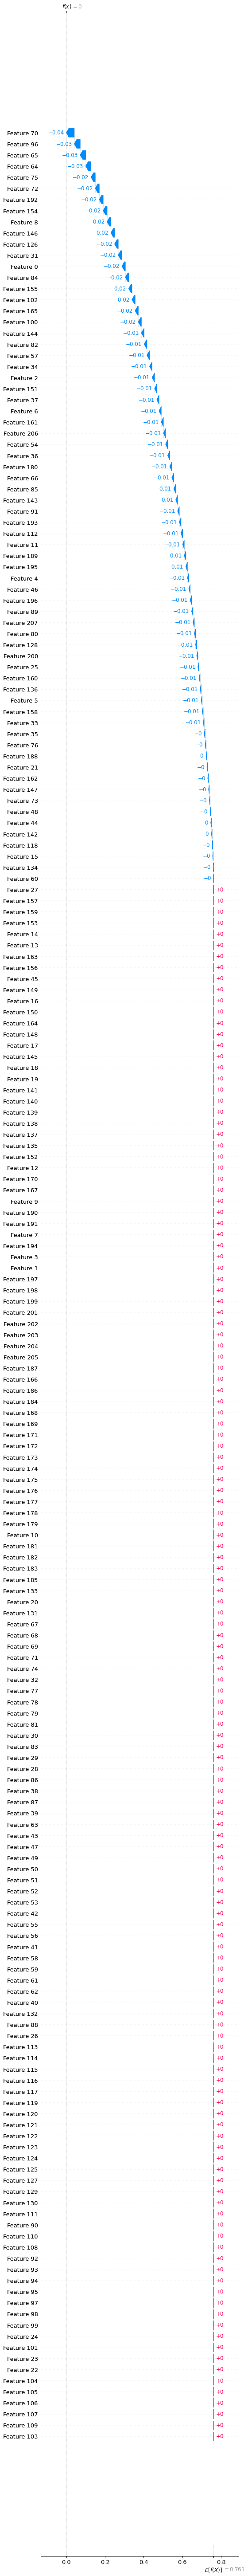

In [70]:
from shap import Explanation
shap.waterfall_plot(Explanation(shap_values[0][0],ke.expected_value[0]), max_display = 500)

## Feature Importance

In [74]:
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_train)

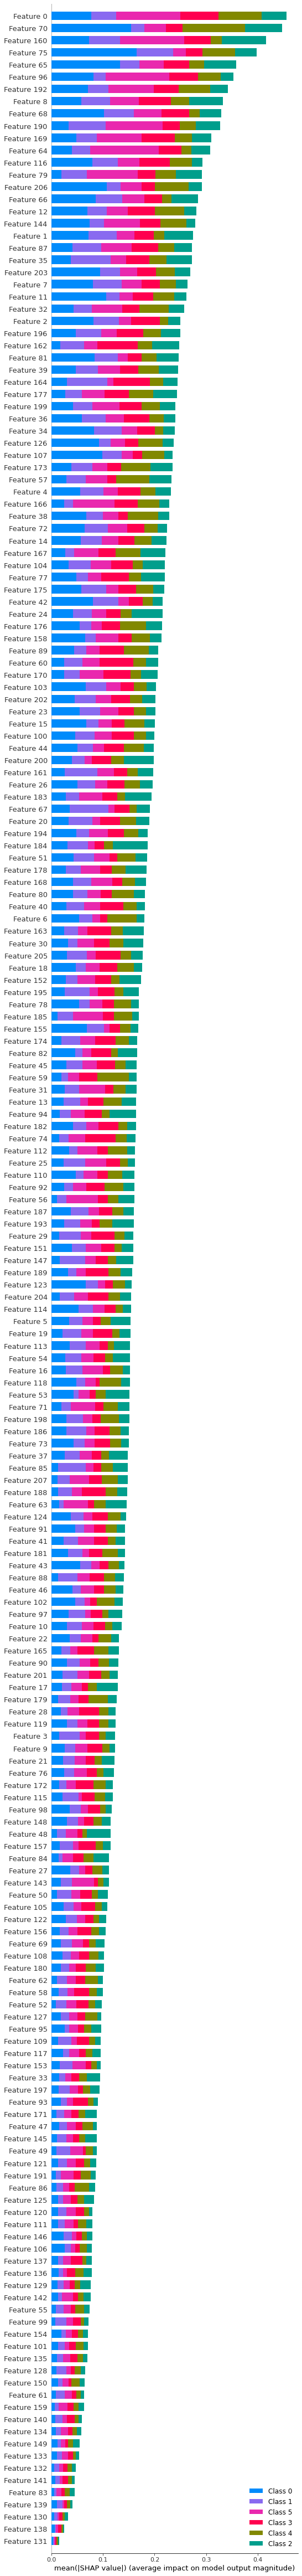

In [76]:
shap.summary_plot(shap_values, X_train, max_display = 500)

In [18]:
from catboost import CatBoostClassifier

model_cb = CatBoostClassifier(iterations = 2000, learning_rate = 0.05, verbose = False, random_state = 50)
for fs in feature_sets:
    X_train = extract_features(train_emg_sub_labels, fs)
    X_test = extract_features(test_emg_sub_labels, fs)
    model_cb.fit(X_train, y_train_sub_labels)
    train_preds = model_cb.predict(X_train)
    test_preds = model_cb.predict(X_test)

    train_acc, bal_train_acc = eval_clf(y_train_sub_labels, train_preds)
    test_acc, bal_test_acc = eval_clf(y_test_sub_labels, test_preds)

    print(f"Features = {fs}")
    print(f"train acc: {train_acc} test acc: {test_acc}")
    print(f"balanced train acc: {bal_train_acc} balanced test acc: {bal_test_acc}")

Features = ['mav', 'ssc', 'zc', 'WL']
train acc: 0.9862076058140598 test acc: 0.8900535490486499
balanced train acc: 0.9661904454325406 balanced test acc: 0.7458685509889941
Features = ['iEMG', 'VAR', 'WL', 'ZC', 'SSC', 'WAMP']
train acc: 0.9890529298839016 test acc: 0.8935855075766207
balanced train acc: 0.9730222995602441 balanced test acc: 0.7537119298232371
Features = ['RMS']
train acc: 0.9894643020385776 test acc: 0.8997835251224792
balanced train acc: 0.9756776832591378 balanced test acc: 0.7747733188136522
Features = ['Mean', 'Var', 'SD']
train acc: 0.9862647408355426 test acc: 0.8960920587900194
balanced train acc: 0.9675037761012045 balanced test acc: 0.7647034005971366
Features = ['Mean', 'Var', 'SD', 'Skewness']
train acc: 0.9888472438065636 test acc: 0.8890281417340777
balanced train acc: 0.9734904558366059 balanced test acc: 0.7472390123208495
Features = ['Mean', 'Var', 'SD', 'Skewness', 'Kurtosis', 'RMS']
train acc: 0.9908126885455709 test acc: 0.8919676427025179
balanced